In [18]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import matplotlib.pyplot as plt
import math
import librosa

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import RandomizedSearchCV

# kNN classifier code

In [ ]:
import numpy as np
from scipy.stats import mode
 
def eucledian(p1,p2):
    dist = np.sqrt(np.sum((p1-p2)**2))
    return dist

def predict(x_train, y , x_input, k):
    op_labels = []
    for item in x_input: 
        point_dist=np.zeros(x_input.shape[0])
        for j in range(len(x_train)): 
            distances = eucledian(np.array(x_train[j,:]) , item)
            point_dist.append(distances) 
        point_dist = np.array(point_dist) 
        dist = np.argsort(point_dist)[:k] 
        labels = y[dist]
        lab = mode(labels) 
        lab = lab.mode[0]
        op_labels.append(lab)
 
    return op_labels

# Feature Extraction

## Vggish

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import librosa
vggmodel = hub.load('https://tfhub.dev/google/vggish/1')

def embedding_from_fn(fn):
    x, sr = librosa.load(fn,sr=None)
    x_16k = librosa.resample(x,sr,16000) #resample to 16KHz
    embedding = np.array(vggmodel(x_16k))
    return embedding

## Info csv load

In [19]:
relevant_genres = ['funk', 'hiphop', 'jazz', 'rock']

In [20]:
from scipy.io.wavfile import read as wavread
def ToolReadAudio(cAudioFilePath):    
    [samplerate, x] = wavread(cAudioFilePath)    
    if x.dtype == 'float32':        
        audio = x    
    else:        
        # change range to [-1,1)        
        if x.dtype == 'uint8':            
            nbits = 8        
        elif x.dtype == 'int16':            
            nbits = 16        
        elif x.dtype == 'int32':            
            nbits = 32        
        audio = x / float(2**(nbits - 1))    
        # special case of unsigned format    
    if x.dtype == 'uint8':        
        audio = audio - 1.    
    return (samplerate, audio)

In [21]:
import pandas as pd
info = pd.read_csv('./groove/info.csv')
#df=info[info['style'].isin(relevant_genres)]

#df.pivot(index='style', columns='beat_type', values='audio_filename')
df = pd.pivot_table(info, values='audio_filename', index=['style'],
                    columns=['beat_type'], aggfunc='count')
#df[df['beat'] >= 20]

info = info[info['style'].isin(relevant_genres)]
info = info[info['beat_type'] == "beat"]
info = info[info['audio_filename'].notna()].reset_index()
#locs = info['audio_filename'].to_numpy()


In [6]:
info.groupby('style').count()

,index,drummer,session,id,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
style,,,,,,,,,,,
funk,28,28,28,28,28,28,28,28,28,28,28
hiphop,28,28,28,28,28,28,28,28,28,28,28
jazz,24,24,24,24,24,24,24,24,24,24,24
rock,171,171,171,171,171,171,171,171,171,171,171


## Loading and Normalizing (and converting to Mono) Audio

In [7]:
info['audio_filename'][0]

'drummer1/session1/1_funk_80_beat_4-4.wav'

In [8]:
sr,audio = ToolReadAudio('./groove/'+'drummer1/session1/1_funk_80_beat_4-4.wav')
audio.shape[-1]

<ipython-input-4-70eaf167f057>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)


2

# Feature Extraction and Pre-Processing

In [22]:
info['audio'] = ''
for index, row in info.iterrows():
    #if index % 10 == 0:
        #print(index)
    try:
        sr,audio = ToolReadAudio('./groove/'+row['audio_filename'])
        if audio.shape[-1] == 2:
            info['audio'][index] = np.mean(audio,axis=1)
        else:
            info['audio'][index] = audio
        #info['audio'][index] = audio
    except Exception as e: # Some files are unable to be read by scipy's wavfile read, so skipping them and removing the corresponding rows
        info.drop(index,inplace=True)
        #print(e)
        
        print("Error, dropping row")
        print(f"size of info is now: {len(info)}")
info.reset_index(drop=True, inplace=True)
info.drop('index',axis=1,inplace=True)

<ipython-input-20-70eaf167f057>:3: WavFileWarning:

Chunk (non-data) not understood, skipping it.

<ipython-input-22-771846dd385f>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-22-771846dd385f>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Error, dropping row
size of info is now: 250
Error, dropping row
size of info is now: 249
Error, dropping row
size of info is now: 248
Error, dropping row
size of info is now: 247


In [23]:
def block_audio(x,blockSize,hopSize,fs):    
    # allocate memory    
    numBlocks = math.ceil(x.size / hopSize)    
    xb = np.zeros([numBlocks, blockSize])    
    # compute time stamps    
    t = (np.arange(0, numBlocks) * hopSize) / fs   
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)    
    for n in range(0, numBlocks):        
        i_start = n * hopSize        
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])        
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]    
    return (xb,t)

In [70]:
xb,t = block_audio(audio,2048,1024,44100)

In [24]:
def agg_mfccs(x):
    mfccs = librosa.feature.mfcc(x,n_mfcc = 13)
    mean = [np.mean(feature) for feature in mfccs]
    std = [np.std(feature) for feature in mfccs]
    mfcc_delta = librosa.feature.delta(mfccs)
    delta_mean=[np.mean(feature) for feature in mfcc_delta]
    delta_std=[np.std(feature) for feature in mfcc_delta]
    return mean,std,delta_mean,delta_std

In [25]:
def extract_spectral_centroid(xb, fs):
    centroids = np.zeros(xb.shape[0])
    stft,freqs = calc_stft(xb,fs)
    #np.sum(magnitudes*freqs) / np.sum(magnitudes)
    for i in range(freqs.shape[0]):
        if np.all(stft[i] == 0):
            pass
        else:
            centroid = np.sum(stft[i]*freqs[i]) / np.sum(stft[i])
            centroids[i]=centroid
        #centroids.append(centroid)
    #centroids=np.array(centroids)
    return centroids

def extract_spectral_centroid(xb, fs):
    centroids = np.zeros(xb.shape[0])
    stft,freqs = calc_stft(xb,fs)
    #np.sum(magnitudes*freqs) / np.sum(magnitudes)
    for i in range(freqs.shape[0]):
        if np.all(stft[i] == 0):
            pass
        else:
            centroid = np.sum(stft[i]*freqs[i]) / np.sum(stft[i])
            centroids[i]=centroid
        #centroids.append(centroid)
    #centroids=np.array(centroids)
    return centroids
def calc_stft(xb,fs=44100):
    stft = np.zeros((xb.shape[0],(int(xb[0].shape[0]/2)+1)))
    freqs = np.zeros((xb.shape[0],(int(xb[0].shape[0]/2)+1)))
    window = np.hanning(xb[0].shape[0])
    for i in range(xb.shape[0]):
        block= xb[i]
        # Apply Window to the block
        windowed_block = window * block 
        stft_blk = np.fft.fft(windowed_block)
        #stft_blk = np.fft.rfft(windowed_block)
        freq=np.fft.fftfreq(block.size,1/fs)
        freqs[i]=freq[:int(block.size/2)+1]
        stft_blk = np.abs(stft_blk)
        #stft_block = stft_blk[int((stft_blk.shape[0])/2):]
        stft_block = stft_blk[:int(((stft_blk.shape[0])/2)+1)]
        #stft_db = 10*np.log10(stft_block) # IS THIS CORRECT??
        stft[i]=stft_block#stft_db
    stft = np.array(stft)
    freqs=np.array(freqs)
    return stft,freqs

def extract_spectral_centroid(xb, fs):
    centroids = np.zeros(xb.shape[0])
    stft,freqs = calc_stft(xb,fs)
    #np.sum(magnitudes*freqs) / np.sum(magnitudes)
    for i in range(freqs.shape[0]):
        if np.all(stft[i] == 0):
            pass
        else:
            centroid = np.sum(stft[i]*freqs[i]) / np.sum(stft[i])
            centroids[i]=centroid
        #centroids.append(centroid)
    #centroids=np.array(centroids)
    return centroids

def extract_rms(xb):
    rms = np.zeros(xb.shape[0])
    for i in range(xb.shape[0]):
        if np.all(xb[i] == 0):
            r = 0.00001
        else:
            block = xb[i]
            r = np.sqrt(np.sum(block**2)/xb.shape[0])
            if r <= 0.00001: # Done to handle case when rms is 0 (for a block of all zeros
                r = 0.00001
            #rms.append(r)
        rms[i] = r
    #rms=np.array(rms)
    return 20*np.log10(rms)#rms,20*np.log10(rms) # What is reference value to convert to dB? Is it 1?

def extract_zerocrossingrate(xb):
    zcr= np.zeros(xb.shape[0])
    for i in range(xb.shape[0]):
        if np.all(xb[i] == 0):
            pass
        else:
            block = xb[i]
            zero_crossings = np.sum(np.abs(np.diff(np.sign(block)))) / block.shape[0] #np.nonzero(np.diff(block > 0))[0].size
            #zcr.append(zero_crossings)
            zcr[i] = zero_crossings 
    #zcr = np.array(zcr)
    return zcr

def extract_spectral_crest(xb):
    crest = np.zeros(xb.shape[0])
    stft,freqs = calc_stft(xb,44100)
    for i in range(stft.shape[0]):
        if np.all(stft[i] == 0):
            pass
        else:
            #crest.append((np.max(stft[i])/np.sum(stft[i])))
            crest[i] = np.max(stft[i])/np.sum(stft[i])
    #crest = np.array(crest)
    return crest

def extract_spectral_flux(xb):
    num_blocks=xb.shape[0] 
    blockSize = xb.shape[1]
    spectral_flux = np.zeros(num_blocks)
    stft,freqs = calc_stft(xb,44100)
    fft_len= stft.shape[1]
    n = 0
    k = 0
    for n in range(1,num_blocks):
        if np.all(stft[n] == 0):
            pass
        else:
            sum_flux = 0
            for k in range(fft_len):
                f = (abs(stft[n, k]) - abs(stft[n-1, k]))**2
                sum_flux += f
            flux = np.sqrt(sum_flux)/((blockSize/2)+1)
            spectral_flux[n] = flux #first flux value will be 0
    return spectral_flux
def get_novelty(xb):
    N = 2048#xb.shape[1]
    w = scipy.signal.hann(N)
    novelty=np.zeros([xb.shape[0],xb.shape[1]])
    for i in range(xb.shape[0]):
        xb_square = xb[i]**2
        energy_local = np.convolve(xb_square, w**2, 'same')
        energy_local_diff = np.diff(energy_local)
        energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
        novelty_energy = np.copy(energy_local_diff)
        novelty_energy[energy_local_diff < 0] = 0
        novelty[i] = novelty_energy
    return novelty
def get_num_onsets(novelty,thresh):
    onsets=np.zeros(novelty.shape[0])
    for i in range(novelty.shape[0]):
        p = scipy.signal.find_peaks(novelty[i])[0]
        onsets[i]=(novelty[i][p] >= thresh).sum()
    return onsets
def get_onset_data(xb,threshold):
    novelty=get_novelty(xb)
    onsets = get_num_onsets(novelty,threshold)
    return onsets#, (onsets/durationInSecs)

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def get_onsets_in_freq_bands(x,blockSize,hopSize,fs,threshold=0.001,fl1=20,fh1=400,fl2=400,fh2=3000,fl3=8000,fh3=15000):
    x1 = butter_bandpass_filter(x,fl1,fh1,fs)
    x2 = butter_bandpass_filter(x,fl2,fh2,fs)
    x3 = butter_bandpass_filter(x,fl3,fh3,fs)

    xb1,_ = block_audio(x1,blockSize,hopSize,fs)
    xb2,_ = block_audio(x2,blockSize,hopSize,fs)
    xb3,_ = block_audio(x3,blockSize,hopSize,fs)

    onsets1 = get_onset_data(xb1,0.0000001)
    onsets2 = get_onset_data(xb2,0.0001)
    onsets3 = get_onset_data(xb3,0.00001)
    return onsets1, onsets2, onsets3

def extract_manual_features(x,fs):

    xb,ts = block_audio(x,2048,1024,fs)
    centroid = extract_spectral_centroid(xb,fs)
    rms = extract_rms(xb)
    zcr = extract_zerocrossingrate(xb)
    crest = extract_spectral_crest(xb)
    flux = extract_spectral_flux(xb)

    centroid_mean = np.mean(centroid)
    centroid_std = np.std(centroid)

    rms_mean = np.mean(rms)
    rms_std = np.std(rms)

    zcr_mean = np.mean(zcr)
    zcr_std = np.std(zcr)

    crest_mean = np.mean(crest)
    crest_std = np.std(crest)

    flux_mean = np.mean(flux)
    flux_std = np.std(flux)

    xb2,ts2 = block_audio(x,int(fs*1),int(fs*0.5),fs)
    onsets = get_onset_data(xb2,0.001)

    onsets_mean = np.mean(onsets)
    onsets_std = np.std(onsets)

    onsets1,onsets2,onsets3 = get_onsets_in_freq_bands(x,2048,1024,fs)
    # onsets1_mean = np.mean(onsets1)
    onsets2_mean = np.mean(onsets2)
    onsets3_mean = np.mean(onsets3)
    
    # onsets1_std = np.std(onsets1)
    onsets2_std = np.std(onsets2)
    onsets3_std = np.std(onsets3)

    return centroid_mean, centroid_std, rms_mean, rms_std, zcr_mean, zcr_std, crest_mean, crest_std, \
        flux_mean,flux_std,onsets_mean,onsets_std,onsets2_mean,onsets3_mean,onsets2_std,onsets3_std

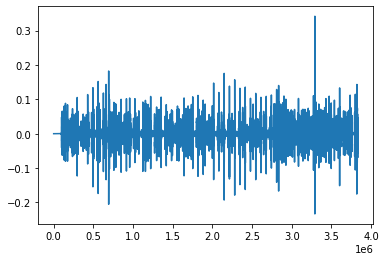

In [75]:
x = df['audio'][0]
x_low=butter_bandpass_filter(x,100,1000,fs)
plt.plot(x_low)

In [63]:
import librosa.display
D = librosa.amplitude_to_db(np.abs(librosa.stft(x_low)), ref=np.max)
librosa.display.specshow(D,sr=44100)

ParameterError: Audio buffer is not finite everywhere

In [58]:
xb2,ts2 = block_audio(x,int(fs*1),int(fs*0.5),fs)
y= get_onset_data(xb2,0.001)
a,b,c=get_onsets_in_freq_bands(x,int(fs*1),int(fs*0.5),fs)
print(y)
print(a)
print(b)
print(c)

<ipython-input-57-11c1127e17f2>:127: RuntimeWarning:

overflow encountered in square



[0. 0. 0. 1. 2. 2. 2. 1. 1. 3. 3. 2. 3. 2. 1. 2. 1. 1. 3. 2. 1. 3. 2. 1.
 3. 3. 1. 2. 3. 2. 3. 4. 2. 3. 3. 2. 3. 3. 2. 3. 4. 3. 3. 2. 1. 3. 3. 2.
 1. 1. 2. 3. 3. 2. 2. 1. 1. 2. 3. 3. 2. 2. 2. 3. 3. 2. 3. 2. 1. 3. 3. 2.
 3. 3. 2. 2. 2. 2. 2. 1. 1. 3. 3. 2. 3. 3. 2. 2. 2. 2. 2. 1. 0. 2. 4. 2.
 2. 2. 1. 3. 4. 2. 2. 2. 0. 3. 5. 3. 3. 3. 1. 2. 4. 3. 3. 4. 2. 2. 4. 3.
 3. 4. 3. 3. 4. 3. 3. 3. 2. 3. 3. 2. 3. 3. 2. 3. 3. 2. 3. 3. 2. 3. 3. 2.
 3. 3. 2. 2. 3. 4. 4. 3. 2. 3. 3. 2. 3. 3. 2. 3. 3. 2. 2. 1. 1. 3. 3. 2.
 3. 2. 1. 3. 5. 3.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [38]:
x = df['audio'][0]
x
fs=44100

In [79]:
df=info
df['mfcc_mean'] = ''
df['mfcc_std'] = ''

df['delta_mfcc_mean'] = ''
df['delta_mfcc_std'] = ''

df['centroid_mean'] = ''
df['centroid_std'] = ''

df['rms_mean'] = ''
df['rms_std'] = ''

df['zcr_mean'] = ''
df['zcr_std'] = ''

df['crest_mean'] = ''
df['crest_std'] = ''

df['flux_mean'] = ''
df['flux_std'] = ''

df['onsets_mean'] = ''
df['onsets_std'] = ''

df['onsets_mid_mean'] = ''
df['onsets_mid_std'] = ''

df['onsets_high_mean'] = ''
df['onsets_high_std'] = ''
for i in range(len(df)):
    #print(df['audio'][i].shape)
    mean,std,delta_mean,delta_std = agg_mfccs(df['audio'][i])
    # Extract 13 MFCCs - get mean and std deviation for each (26 features) + Delta MFCCs (26 features) = total 52 Features
    df['mfcc_mean'][i] = mean
    df['mfcc_std'][i] = std
    df['delta_mfcc_mean'][i] = delta_mean
    df['delta_mfcc_std'][i] = delta_std

    centroid_mean, centroid_std, rms_mean, rms_std, zcr_mean, zcr_std, crest_mean, crest_std, flux_mean,flux_std,onsets_mean,onsets_std,onsets2_mean,onsets3_mean,onsets2_std,onsets3_std \
         = extract_manual_features(df['audio'][i],44100)
    df['centroid_mean'][i] = centroid_mean
    df['centroid_std'][i] = centroid_std
    df['rms_mean'][i] = rms_mean
    df['rms_std'][i] = rms_std
    df['zcr_mean'][i] = zcr_mean
    df['zcr_std'][i] = zcr_std
    df['crest_mean'][i] = crest_mean
    df['crest_std'][i] = crest_std
    df['flux_mean'][i] = flux_mean
    df['flux_std'][i] = flux_std
    df['onsets_mean'][i] = onsets_mean
    df['onsets_std'][i] = onsets_std

    # df['onsets_low_mean'][i] = onsets1_mean
    # df['onsets_low_std'][i] = onsets1_std

    df['onsets_mid_mean'][i] = onsets2_mean
    df['onsets_mid_std'][i] = onsets2_std

    df['onsets_high_mean'][i] = onsets3_mean
    df['onsets_high_std'][i] = onsets3_std


df[['mfcc1_mean','mfcc2_mean','mfcc3_mean','mfcc4_mean','mfcc5_mean','mfcc6_mean','mfcc7_mean','mfcc8_mean','mfcc9_mean','mfcc10_mean','mfcc11_mean','mfcc12_mean','mfcc13_mean']]=pd.DataFrame(df.mfcc_mean.tolist(), index= df.index)
df[['mfcc1_std','mfcc2_std','mfcc3_std','mfcc4_std','mfcc5_std','mfcc6_std','mfcc7_std','mfcc8_std','mfcc9_std','mfcc10_std','mfcc11_std','mfcc12_std','mfcc13_std']]=pd.DataFrame(df.mfcc_std.tolist(), index= df.index)

df[['delta_mfcc1_mean','delta_mfcc2_mean','delta_mfcc3_mean','delta_mfcc4_mean','delta_mfcc5_mean','delta_mfcc6_mean','delta_mfcc7_mean','delta_mfcc8_mean','delta_mfcc9_mean','delta_mfcc10_mean','delta_mfcc11_mean','delta_mfcc12_mean','delta_mfcc13_mean']]=pd.DataFrame(df.delta_mfcc_mean.tolist(), index= df.index)
df[['delta_mfcc1_std','delta_mfcc2_std','delta_mfcc3_std','delta_mfcc4_std','delta_mfcc5_std','delta_mfcc6_std','delta_mfcc7_std','delta_mfcc8_std','delta_mfcc9_std','delta_mfcc10_std','delta_mfcc11_std','delta_mfcc12_std','delta_mfcc13_std']]=pd.DataFrame(df.delta_mfcc_std.tolist(), index= df.index)


<ipython-input-79-7e338f95f05a>:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-79-7e338f95f05a>:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-79-7e338f95f05a>:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-79-7e338f95f05a>:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

In [80]:
out = df.to_numpy()
np.save('./resources/working_data/data.npy', out)

In [81]:
df.columns

Index(['drummer', 'session', 'id', 'style', 'bpm', 'beat_type',
       'time_signature', 'midi_filename', 'audio_filename', 'duration',
       'split', 'audio', 'mfcc_mean', 'mfcc_std', 'delta_mfcc_mean',
       'delta_mfcc_std', 'centroid_mean', 'centroid_std', 'rms_mean',
       'rms_std', 'zcr_mean', 'zcr_std', 'crest_mean', 'crest_std',
       'flux_mean', 'flux_std', 'onsets_mean', 'onsets_std', 'mfcc1_mean',
       'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean',
       'mfcc7_mean', 'mfcc8_mean', 'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean',
       'mfcc12_mean', 'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std',
       'mfcc4_std', 'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std',
       'mfcc9_std', 'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
 

# Load Feature file and classify

## Load Feature File

In [26]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import matplotlib.pyplot as plt
import math
import librosa
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score,f1_score
from sklearn.model_selection import cross_validate
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
names=['drummer', 'session', 'id', 'style', 'bpm', 'beat_type',
       'time_signature', 'midi_filename', 'audio_filename', 'duration',
       'split', 'audio', 'mfcc_mean', 'mfcc_std', 'delta_mfcc_mean',
       'delta_mfcc_std', 'centroid_mean', 'centroid_std', 'rms_mean',
       'rms_std', 'zcr_mean', 'zcr_std', 'crest_mean', 'crest_std',
       'flux_mean', 'flux_std', 'onsets_mean', 'onsets_std', 'mfcc1_mean',
       'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean',
       'mfcc7_mean', 'mfcc8_mean', 'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean',
       'mfcc12_mean', 'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std',
       'mfcc4_std', 'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std',
       'mfcc9_std', 'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std', 'onsets_low_mean',
       'onsets_low_std','onsets_mid_mean', 'onsets_mid_std',
       'onsets_high_mean', 'onsets_high_std']
df=pd.DataFrame(np.load('./resources/working_data/data.npy',allow_pickle=True),columns=names)

In [27]:
import plotly.express as px
lst=df.columns
lst=['style','bpm','mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std',\
       'centroid_mean','centroid_std','rms_mean','rms_std','zcr_mean','zcr_std','crest_mean','crest_std','flux_mean','flux_std','onsets_mean', 'onsets_std','onsets_mid_mean', 'onsets_mid_std',
       'onsets_high_mean', 'onsets_high_std']
fig = px.scatter_matrix(df[lst],dimensions=['mfcc1_mean', 'mfcc2_mean','onsets_mean','onsets_std','bpm'],color='style')
fig.show()

### Feature Normalization and train-test split

In [99]:
df

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,...,delta_mfcc10_std,delta_mfcc11_std,delta_mfcc12_std,delta_mfcc13_std,onsets_low_mean,onsets_low_std,onsets_mid_mean,onsets_mid_std,onsets_high_mean,onsets_high_std
0,drummer1,drummer1/session1,drummer1/session1/1,funk,80,beat,4-4,drummer1/session1/1_funk_80_beat_4-4.mid,drummer1/session1/1_funk_80_beat_4-4.wav,86.704688,...,1.366241,1.161793,0.966226,0.962835,,,0.030166,0.171043,0.176989,0.386524
1,drummer1,drummer1/session1,drummer1/session1/102,funk,95,beat,4-4,drummer1/session1/102_funk_95_beat_4-4.mid,drummer1/session1/102_funk_95_beat_4-4.wav,224.807558,...,1.304854,1.059812,1.017045,1.017376,,,0.140688,0.363956,0.258961,0.468377
2,drummer1,drummer1/session1,drummer1/session1/2,funk,80,beat,4-4,drummer1/session1/2_funk_80_beat_4-4.mid,drummer1/session1/2_funk_80_beat_4-4.wav,86.914062,...,1.258876,1.048738,0.897463,0.908775,,,0.032034,0.176091,0.139883,0.353724
3,drummer1,drummer1/session1,drummer1/session1/3,funk,80,beat,4-4,drummer1/session1/3_funk_80_beat_4-4.mid,drummer1/session1/3_funk_80_beat_4-4.wav,122.851562,...,1.208663,0.943772,0.90037,0.973241,,,0.049868,0.22026,0.164715,0.381467
4,drummer1,drummer1/session1,drummer1/session1/47,jazz,102,beat,4-4,drummer1/session1/47_jazz_102_beat_4-4.mid,drummer1/session1/47_jazz_102_beat_4-4.wav,183.415349,...,1.060434,0.949308,1.027447,0.852236,,,0.03397,0.185349,0.142418,0.361025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,drummer9,drummer9/session1,drummer9/session1/5,rock,100,beat,4-4,drummer9/session1/5_rock_100_beat_4-4.mid,drummer9/session1/5_rock_100_beat_4-4.wav,71.78,...,1.170351,1.161183,1.136704,1.0122,,,0.078039,0.268233,0.177362,0.398502
243,drummer9,drummer9/session1,drummer9/session1/6,rock,100,beat,4-4,drummer9/session1/6_rock_100_beat_4-4.mid,drummer9/session1/6_rock_100_beat_4-4.wav,4.74875,...,1.077896,1.273932,0.874763,0.882934,,,0.039024,0.193653,0.126829,0.332782
244,drummer9,drummer9/session1,drummer9/session1/7,rock,100,beat,4-4,drummer9/session1/7_rock_100_beat_4-4.mid,drummer9/session1/7_rock_100_beat_4-4.wav,23.93875,...,1.192762,1.090079,1.13261,1.10033,,,0.058027,0.233795,0.235977,0.442454
245,drummer9,drummer9/session1,drummer9/session1/8,rock,100,beat,4-4,drummer9/session1/8_rock_100_beat_4-4.mid,drummer9/session1/8_rock_100_beat_4-4.wav,11.20875,...,1.335897,1.109056,1.246564,1.127368,,,0.087576,0.282678,0.234216,0.437697


In [30]:
X.shape

(247, 42)

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(172, 42)
(172, 1)
(75, 42)
(75, 1)


In [33]:
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning) 
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Results with MFCCs + Delta MFCCs

In [21]:
print("-------------------------------------------------------------------------------")
print("            KNN with k=4              ")
print("-------------------------------------------------------------------------------")
k=4
KNN_model = KNeighborsClassifier(n_neighbors=k)
KNN_model.fit(X_train, y_train)
KNN_prediction = KNN_model.predict(X_test)
score=precision_score(y_test, KNN_prediction, average='macro')
accuracy = accuracy_score(y_test, KNN_prediction)
cm = confusion_matrix(y_test, KNN_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(f"Confusion Matrix:\n {cm}")
print(f"Accuracy score: {accuracy}")
print(f"Macro accuracy score: {score}")

print("-------------------------------------------------------------------------------")
print("            SVM with C=1, kernel = rbf, degree = 3              ")
print("-------------------------------------------------------------------------------")

SVM_model = make_pipeline(StandardScaler(), SVC(gamma='auto',C=1.0, kernel='rbf', degree=3,random_state=None))
SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
accuracy = accuracy_score(y_test, SVM_prediction)
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(f"Confusion Matrix:\n {cm}")
print(f"Accuracy score: {accuracy}")
print(f"Macro accuracy score: {score}")

print("-------------------------------------------------------------------------------")
print("            RF with n_estimators = 100, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto', max_leaf_nodes=None,class_weight='balanced'              ")
print("-------------------------------------------------------------------------------")

RF_model = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced')
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test, RF_prediction, average='macro')
accuracy = accuracy_score(y_test, RF_prediction)
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(f"Confusion Matrix:\n {cm}")
print(f"Accuracy score: {accuracy}")
print(f"Macro accuracy score: {score}")

-------------------------------------------------------------------------------
            KNN with k=4              
-------------------------------------------------------------------------------
Confusion Matrix:
 [[ 6  1  0  2]
 [ 1  4  0  6]
 [ 0  0  6  2]
 [ 4  6  3 41]]
Accuracy score: 0.6951219512195121
Macro accuracy score: 0.5949197860962567
-------------------------------------------------------------------------------
            SVM with C=1, kernel = rbf, degree = 3              
-------------------------------------------------------------------------------
Confusion Matrix:
 [[ 0  0  0  9]
 [ 0  0  0 11]
 [ 0  0  1  7]
 [ 0  0  0 54]]
Accuracy score: 0.6707317073170732
Macro accuracy score: 0.41666666666666663
-------------------------------------------------------------------------------
            RF with n_estimators = 100, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto', max_leaf_nodes=None,class_weight='balanced'        

## Overall Hyperparameter Optimization

In [22]:
print("-------------------------------------------------------------------------------")
print("            KNN             ")
print("{'n_neighbors': 9}")
print("-------------------------------------------------------------------------------")
k= [int(x) for x in range(4,10)]
knn_grid = {'n_neighbors':k}


knn = KNeighborsClassifier()
KNN_model=RandomizedSearchCV(estimator = knn, param_distributions=knn_grid,cv=10,verbose=2,n_jobs=1)
KNN_model.fit(X_train, y_train)
print(KNN_model.best_params_)
print(f'Training CV Accuracy: {KNN_model.best_score_}')
KNN_prediction = KNN_model.predict(X_test)
score=precision_score(y_test, KNN_prediction, average='macro')
accuracy = accuracy_score(y_test, KNN_prediction)
cm = confusion_matrix(y_test, KNN_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(f"Confusion Matrix:\n {cm}")
print(f"Accuracy score: {accuracy}")
print(f"Macro accuracy score: {score}")

print("-------------------------------------------------------------------------------")
print("            SVM             ")
print("{'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'decision_function_shape': 'ovr', 'coef0': 3.2, 'C': 1.053646986645436}")
print("-------------------------------------------------------------------------------")

C = [x**0.01 for x in range(25,200)]
kernel = ['rbf','linear','poly','sigmoid']
degree = [int(x) for x in range(1,8)]
gamma = ['scale','auto']
coef0 = [x*0.1 for x in range(0,40)]
decision_function_shape = ['ovo','ovr']

svm_grid = { 'C' : C,
            'kernel' : kernel,
            'degree' : degree,
            'gamma' : gamma,
            'coef0' : coef0,
            'decision_function_shape' : decision_function_shape
            }

svc = SVC(random_state=0)


svc_RandomGrid = RandomizedSearchCV(estimator = svc, param_distributions=svm_grid,cv=10,verbose=2,n_jobs=4)
svc_RandomGrid.fit(X_train,y_train)
print(svc_RandomGrid.best_params_)
y_prediction = svc_RandomGrid.predict(X_test)
score=precision_score(y_test, y_prediction, average='macro')
accuracy = accuracy_score(y_test, y_prediction)
cm = confusion_matrix(y_test, y_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(f"Confusion Matrix:\n {cm}")
print(f"Accuracy score: {accuracy}")
print(f"Macro accuracy score: {score}")

print("-------------------------------------------------------------------------------")
print("            Random Forest             ")
print("{'n_estimators': 650, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': 30, 'max_depth': 46, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}")
print("-------------------------------------------------------------------------------")

n_estimators= [x for x in range(10,1000,10)]
criterion=['gini','entropy']

max_depth=[y for y in range(1,1000,5)]
max_depth.append(None)

min_samples_split=[x for x in range(2,10)]
min_samples_leaf=[x for x in range(1,10)]
max_features=[x for x in range(0,100)]
max_features.append('auto')
max_features.append('sqrt')
max_features.append('log2')
max_leaf_nodes=[x for x in range(0,100)]
class_weight=['balanced','balanced_subsample']


rf_grid = { 'n_estimators' : n_estimators,
            'criterion' : criterion,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'max_features': max_features,
            'max_leaf_nodes': max_leaf_nodes,
            'class_weight': class_weight 
            }

rf = RandomForestClassifier(random_state=0)
RF_model = RandomizedSearchCV(estimator = rf, param_distributions=rf_grid,cv=10,verbose=2,n_jobs=4)
RF_model.fit(X_train, y_train)
print(RF_model.best_params_)
RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test, RF_prediction, average='macro')
accuracy = accuracy_score(y_test, RF_prediction)
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(f"Confusion Matrix:\n {cm}")
print(f"Accuracy score: {accuracy}")
print(f"Macro accuracy score: {score}")

-------------------------------------------------------------------------------
            KNN             
{'n_neighbors': 9}
-------------------------------------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[C

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ......................................n_neighbors=9; total time=   0.0s
[CV] END ......................................n_neighbors=9; total time=   0.0s
[CV] END ......................................n_neighbors=9; total time=   0.0s
[CV] END ......................................n_neighbors=9; total time=   0.0s
[CV] END ......................................n_neighbors=9; total time=   0.0s
[CV] END ......................................n_neighbors=9; total time=   0.0s
{'n_neighbors': 5}
Training CV Accuracy: 0.7161764705882353
Confusion Matrix:
 [[ 6  0  0  3]
 [ 1  4  0  6]
 [ 0  0  3  5]
 [ 5  2  3 44]]
Accuracy score: 0.6951219512195121
Macro accuracy score: 0.6063218390804597
-------------------------------------------------------------------------------
            SVM             
{'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'decision_function_shape': 'ovr', 'coef0': 3.2, 'C': 1.053646986645436}
-------------------------------------------------------------------

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.70808824 0.72683824 0.62904412 0.76323529
        nan 0.61727941        nan 0.61066176]
  warnings.warn(


{'n_estimators': 910, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_leaf_nodes': 94, 'max_features': 51, 'max_depth': 896, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}
Confusion Matrix:
 [[ 2  2  0  5]
 [ 0  5  0  6]
 [ 0  0  4  4]
 [ 1  1  1 51]]
Accuracy score: 0.7560975609756098
Macro accuracy score: 0.7160984848484848


# Hyperparameter tuning

## Best Results:



RF:  
accuracy                                                     0.743902  
macro_accuracy                                               0.678571  
{'n_estimators': 800,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 29,
 'max_features': 45,
 'max_depth': 796,
 'criterion': 'entropy',
 'class_weight': 'balanced'}


SVM: 

accuracy 0.8658536585365854  
macro-accuracy 0.8566308243727598  
[[ 5  1  0  3]  
 [ 0  8  0  3]  
 [ 0  0  4  2]  
 [ 0  0  2 54]]  
{'kernel': 'poly', 'gamma': 'auto', 'degree': 4, 'decision_function_shape': 'ovr', 'coef0': 0.9, 'C': 1.051659640188661}

accuracy                                                     0.8414634146341463  
macro_accuracy                                               0.8418898809523809  
{'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'decision_function_shape': 'ovr', 'coef0': 1.1, 'C': 1.053359910724275}

accuracy                                                     0.780488  
macro_accuracy                                               0.728571  
{'kernel': 'poly',
 'gamma': 'scale',
 'degree': 3,
 'decision_function_shape': 'ovr',
 'coef0': 0.7000000000000001,
 'C': 1.053475672085955}

accuracy              0.792683  
macro_accuracy        0.768056  
 {'kernel': 'poly',
 'gamma': 'scale',
 'degree': 7,
 'decision_function_shape': 'ovr',
 'coef0': 0.6000000000000001,
 'C': 1.053646986645436}


### SVM Params

In [52]:
warnings.filterwarnings("ignore")

C = [x**0.01 for x in range(25,200)]
kernel = ['rbf','linear','poly','sigmoid']
degree = [int(x) for x in range(1,8)]
gamma = ['scale','auto']
coef0 = [x*0.1 for x in range(0,40)]
decision_function_shape = ['ovo','ovr']

svm_grid = { 'C' : C,
            'kernel' : kernel,
            'degree' : degree,
            'gamma' : gamma,
            'coef0' : coef0,
            'decision_function_shape' : decision_function_shape
            }

svc = SVC()
svm_df=pd.DataFrame()
svm_df['trial']=[]
svm_df['accuracy'] = []
svm_df['macro_accuracy'] = []
svm_df['confusion_matrix']=[]
svm_df['params']=[]
svm_df['cv_acc']=[]
svm_df['cv_std']=[]

trial=[]
accuracy=[]
macro_accuracy=[]
confusion=[]
params=[]
cv_acc=[]
cv_std=[]
for i in range(0,50):
    trial.append(i)
    svc_RandomGrid = RandomizedSearchCV(estimator = svc, param_distributions=svm_grid,cv=10,verbose=0,n_jobs=4) #verbose=2
    svc_RandomGrid.fit(X_train,y_train)
    #print(svc_RandomGrid.best_params_)
    params.append(svc_RandomGrid.best_params_)
    y_prediction = svc_RandomGrid.predict(X_test)
    score=precision_score(y_test, y_prediction, average='macro')
    acc = accuracy_score(y_test, y_prediction)
    cm = confusion_matrix(y_test, y_prediction) # clean, highfry, layered, lowfry, midfry, no vocals

    accuracy.append(acc)
    macro_accuracy.append(score)
    confusion.append(cm)
    scores = cross_validate(svc_RandomGrid, X_train, y_train, cv=5)
    cv_acc.append(scores['test_score'].mean())
    cv_std.append(scores['test_score'].std())
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))
    #print(f"Confusion Matrix:\n {cm}")
    #print(f"Accuracy score: {accuracy}")
    #print(f"Macro accuracy score: {score}")


svm_df['trial']= trial
svm_df['accuracy'] = accuracy
svm_df['macro_accuracy'] = macro_accuracy
svm_df['confusion_matrix']=confusion
svm_df['params']=params
svm_df['cv_acc']=cv_acc
svm_df['cv_std']=cv_std

svm_df['macro_accuracy'].max()

Accuracy: 0.68 (+/- 0.05)
Accuracy: 0.67 (+/- 0.08)
Accuracy: 0.71 (+/- 0.10)
Accuracy: 0.70 (+/- 0.13)
Accuracy: 0.72 (+/- 0.10)
Accuracy: 0.70 (+/- 0.06)
Accuracy: 0.68 (+/- 0.05)
Accuracy: 0.70 (+/- 0.12)
Accuracy: 0.67 (+/- 0.07)
Accuracy: 0.69 (+/- 0.10)
Accuracy: 0.70 (+/- 0.10)
Accuracy: 0.71 (+/- 0.12)
Accuracy: 0.71 (+/- 0.12)
Accuracy: 0.73 (+/- 0.17)
Accuracy: 0.71 (+/- 0.03)
Accuracy: 0.72 (+/- 0.12)
Accuracy: 0.71 (+/- 0.11)
Accuracy: 0.71 (+/- 0.17)
Accuracy: 0.68 (+/- 0.12)
Accuracy: 0.67 (+/- 0.11)
Accuracy: 0.76 (+/- 0.13)
Accuracy: 0.68 (+/- 0.10)
Accuracy: 0.70 (+/- 0.15)
Accuracy: 0.72 (+/- 0.12)
Accuracy: 0.70 (+/- 0.10)
Accuracy: 0.70 (+/- 0.05)
Accuracy: 0.69 (+/- 0.12)
Accuracy: 0.70 (+/- 0.11)
Accuracy: 0.68 (+/- 0.08)
Accuracy: 0.70 (+/- 0.12)
Accuracy: 0.73 (+/- 0.07)
Accuracy: 0.69 (+/- 0.06)
Accuracy: 0.72 (+/- 0.14)
Accuracy: 0.67 (+/- 0.05)
Accuracy: 0.70 (+/- 0.08)
Accuracy: 0.70 (+/- 0.12)
Accuracy: 0.68 (+/- 0.09)
Accuracy: 0.70 (+/- 0.10)
Accuracy: 0.

0.8526915113871636

In [54]:
svm_df

,trial,accuracy,macro_accuracy,confusion_matrix,params,cv_acc,cv_std
0,0,0.743902,0.690947,"[[5, 0, 0, 0], [0, 4, 0, 6], [1, 0, 6, 7], [3,...","{'kernel': 'poly', 'gamma': 'scale', 'degree':...",0.684848,0.024242
1,1,0.756098,0.805465,"[[5, 0, 0, 0], [0, 1, 0, 9], [1, 0, 6, 7], [1,...","{'kernel': 'poly', 'gamma': 'auto', 'degree': ...",0.672727,0.040202
2,2,0.731707,0.805556,"[[2, 0, 0, 3], [0, 1, 0, 9], [1, 0, 5, 8], [0,...","{'kernel': 'poly', 'gamma': 'auto', 'degree': ...",0.709091,0.049237
3,3,0.768293,0.752480,"[[5, 0, 0, 0], [0, 3, 0, 7], [1, 0, 6, 7], [2,...","{'kernel': 'poly', 'gamma': 'auto', 'degree': ...",0.696970,0.066391
4,4,0.756098,0.716667,"[[5, 0, 0, 0], [0, 5, 0, 5], [1, 0, 5, 8], [2,...","{'kernel': 'poly', 'gamma': 'auto', 'degree': ...",0.721212,0.052135
5,5,0.646341,0.161585,"[[0, 0, 0, 5], [0, 0, 0, 10], [0, 0, 0, 14], [...","{'kernel': 'sigmoid', 'gamma': 'auto', 'degree...",0.703030,0.029691
6,6,0.743902,0.782212,"[[5, 0, 0, 0], [0, 1, 0, 9], [1, 0, 6, 7], [2,...","{'kernel': 'poly', 'gamma': 'scale', 'degree':...",0.678788,0.024242
7,7,0.768293,0.733924,"[[5, 0, 0, 0], [0, 4, 0, 6], [1, 0, 6, 7], [2,...","{'kernel': 'poly', 'gamma': 'scale', 'degree':...",0.703030,0.061806
8,8,0.743902,0.700063,"[[5, 0, 0, 0], [0, 4, 0, 6], [1, 0, 5, 8], [2,...","{'kernel': 'poly', 'gamma': 'scale', 'degree':...",0.672727,0.035339
9,9,0.756098,0.728311,"[[5, 0, 0, 0], [0, 3, 0, 7], [1, 0, 5, 8], [1,...","{'kernel': 'poly', 'gamma': 'scale', 'degree':...",0.690909,0.052135


In [55]:
import plotly.express as px
px.line(svm_df,x='trial',y=['accuracy','macro_accuracy','cv_acc'])

In [47]:
scores

{'fit_time': array([0.2358551 , 0.19817901, 0.18565202, 0.17781711, 0.17850208]),
 'score_time': array([0.00116277, 0.00046206, 0.00048494, 0.00041485, 0.00072408]),
 'test_score': array([0.6969697 , 0.81818182, 0.81818182, 0.72727273, 0.63636364])}

In [53]:
scores = cross_validate(SVC(kernel='poly',gamma='scale',degree=3,decision_function_shape='ovr',coef0=0.7000000000000001,C=1.053475672085955,random_state=0), X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Accuracy: 0.75 (+/- 0.09)


In [32]:
svm_df[svm_df['macro_accuracy'] == svm_df['macro_accuracy'].max() ]

,trial,accuracy,macro_accuracy,confusion_matrix,params
37,37,0.865854,0.856631,"[[5, 1, 0, 3], [0, 8, 0, 3], [0, 0, 4, 2], [0,...","{'kernel': 'poly', 'gamma': 'auto', 'degree': ..."


In [34]:
for val in svm_df.loc[37]:
    print(val)

37
0.8658536585365854
0.8566308243727598
[[ 5  1  0  3]
 [ 0  8  0  3]
 [ 0  0  4  2]
 [ 0  0  2 54]]
{'kernel': 'poly', 'gamma': 'auto', 'degree': 4, 'decision_function_shape': 'ovr', 'coef0': 0.9, 'C': 1.051659640188661}


In [19]:
df.loc[44]

trial                                                              44
accuracy                                                     0.792683
macro_accuracy                                               0.768056
confusion_matrix    [[2, 0, 0, 5], [0, 2, 0, 5], [1, 0, 3, 4], [0,...
params              {'kernel': 'poly', 'gamma': 'scale', 'degree':...
Name: 44, dtype: object

In [9]:
df.loc[5]

trial                                                               5
accuracy                                                     0.780488
macro_accuracy                                               0.728571
confusion_matrix    [[3, 0, 0, 4], [1, 1, 0, 5], [1, 0, 3, 4], [0,...
params              {'kernel': 'poly', 'gamma': 'scale', 'degree':...
Name: 5, dtype: object

Current best results:

SVM:  
accuracy                                                     0.780488  
macro_accuracy                                               0.728571  
{'kernel': 'poly',
 'gamma': 'scale',
 'degree': 3,
 'decision_function_shape': 'ovr',
 'coef0': 0.7000000000000001,
 'C': 1.053475672085955}

accuracy              0.792683  
macro_accuracy        0.768056  
 {'kernel': 'poly',
 'gamma': 'scale',
 'degree': 7,
 'decision_function_shape': 'ovr',
 'coef0': 0.6000000000000001,
 'C': 1.053646986645436}

### Random Forest Tuning

In [21]:
n_estimators= [x for x in range(10,1000,10)]
criterion=['gini','entropy']

max_depth=[y for y in range(1,1000,5)]
max_depth.append(None)

min_samples_split=[x for x in range(2,10)]
min_samples_leaf=[x for x in range(1,10)]
max_features=[x for x in range(0,100)]
max_features.append('auto')
max_features.append('sqrt')
max_features.append('log2')
max_leaf_nodes=[x for x in range(0,100)]
class_weight=['balanced','balanced_subsample']
rf_grid = { 'n_estimators' : n_estimators,
            'criterion' : criterion,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'max_features': max_features,
            'max_leaf_nodes': max_leaf_nodes,
            'class_weight': class_weight 
            }
rf_df=pd.DataFrame()
rf_df['trial']=[]
rf_df['accuracy'] = []
rf_df['macro_accuracy'] = []
rf_df['confusion_matrix']=[]
rf_df['params']=[]

trial=[]
accuracy=[]
macro_accuracy=[]
confusion=[]
params=[]

rf = RandomForestClassifier(random_state=0)
RF_model = RandomizedSearchCV(estimator = rf, param_distributions=rf_grid,cv=10,verbose=2,n_jobs=4)
for i in range(0,200):
    trial.append(i)
    RF_model.fit(X_train, y_train)
    #print(RF_model.best_params_)
    params.append(RF_model.best_params_)
    RF_prediction = RF_model.predict(X_test)
    score=precision_score(y_test, RF_prediction, average='macro')
    acc = accuracy_score(y_test, RF_prediction)
    cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals

    accuracy.append(acc)
    macro_accuracy.append(score)
    confusion.append(cm)
    #print(f"Confusion Matrix:\n {cm}")
    #print(f"Accuracy score: {accuracy}")
    #print(f"Macro accuracy score: {score}")

rf_df['trial']= trial
rf_df['accuracy'] = accuracy
rf_df['macro_accuracy'] =  macro_accuracy
rf_df['confusion_matrix']= confusion
rf_df['params']= params
rf_df['macro_accuracy'].max()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.41617647        nan 0.67316176        nan 0.62389706 0.62463235
 0.75735294 0.65992647 0.58823529 0.73308824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.67904412        nan        nan 0.71507353
 0.69117647 0.72095588 0.61139706 0.73308824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73308824 0.73308824 0.39154412 0.62977941        nan 0.71507353
 0.68492647 0.70367647        nan 0.65367647]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.70294118 0.76323529 0.74558824        nan        nan 0.69742647
        nan        nan 0.64191176 0.58676471]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.73897059 0.29448529 0.73933824 0.57573529        nan
 0.73970588 0.73933824        nan 0.73308824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.62352941        nan        nan 0.62389706        nan
 0.76985294        nan        nan 0.74558824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.61727941 0.71507353 0.59963235 0.62977941 0.75772059 0.61764706
        nan 0.66029412 0.75110294 0.64779412]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.72095588        nan        nan 0.67904412        nan        nan
 0.74595588 0.73382353 0.75147059 0.76948529]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73897059 0.57536765 0.73308824 0.73933824 0.72095588 0.73308824
 0.62941176        nan 0.74522059 0.73308824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.25992647        nan        nan 0.58786765        nan
        nan        nan 0.6125            nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.56911765        nan        nan 0.64779412        nan        nan
        nan 0.65404412        nan 0.67279412]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.69705882        nan        nan        nan 0.70955882        nan
 0.64080882        nan 0.73308824 0.72610294]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.72132353 0.78198529        nan        nan 0.72095588 0.74522059
 0.66617647        nan 0.72720588        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73382353        nan 0.72058824        nan        nan 0.74522059
 0.24816176 0.66029412        nan 0.64816176]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.71507353 0.69742647 0.72720588 0.61727941        nan
 0.67242647 0.76323529 0.60036765 0.48345588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.69080882 0.67904412 0.75698529
        nan        nan 0.64191176 0.72132353]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.73933824        nan 0.52095588 0.73345588        nan
        nan 0.64191176 0.61102941        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.70919118 0.61727941        nan        nan        nan        nan
 0.73897059 0.76360294 0.75110294 0.72757353]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.69632353        nan        nan        nan
        nan 0.69117647        nan 0.62977941]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.76948529 0.50882353 0.70257353 0.66066176 0.63014706
 0.68455882 0.73897059 0.66727941        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.74522059        nan 0.73272059        nan        nan 0.69705882
 0.62977941        nan 0.73933824 0.76360294]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.72720588        nan        nan
        nan 0.61838235 0.60036765        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.71507353 0.62352941        nan        nan 0.65441176        nan
 0.62977941        nan        nan 0.59411765]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.75147059        nan 0.75110294 0.73860294 0.77536765
        nan        nan 0.75147059 0.66691176]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.67279412        nan        nan 0.62977941 0.76360294 0.46470588
 0.71544118 0.62316176        nan 0.73933824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.62977941 0.71507353 0.60551471        nan
 0.65992647 0.39816176 0.58713235        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.24117647        nan        nan 0.60588235        nan        nan
 0.62977941 0.68419118        nan 0.72720588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73345588        nan 0.5875     0.72794118 0.73933824 0.61727941
        nan        nan 0.575      0.76397059]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.67205882 0.41691176 0.73308824        nan        nan 0.72647059
 0.75698529        nan 0.75735294 0.73933824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.75147059 0.70808824 0.74522059 0.65477941 0.72647059 0.76286765
 0.70882353        nan 0.74522059        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.70294118        nan 0.73272059        nan
 0.66691176        nan 0.57573529 0.71470588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.73897059        nan
 0.64301471        nan 0.59301471        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.575      0.75808824        nan
 0.5875     0.70919118 0.64227941 0.64227941]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73897059        nan 0.75735294        nan 0.65441176        nan
        nan 0.73897059        nan 0.59963235]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73970588        nan 0.64816176        nan 0.73308824 0.74558824
 0.75147059        nan 0.73345588 0.74522059]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.72720588        nan 0.65514706        nan        nan        nan
 0.64264706 0.72169118 0.61948529        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.70955882 0.73897059 0.66617647 0.70330882 0.61691176 0.72720588
        nan        nan 0.70257353 0.75183824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.71066176 0.64338235        nan        nan 0.75073529        nan
        nan 0.59411765 0.75735294        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.74522059        nan        nan 0.72720588 0.69705882 0.75110294
 0.73272059        nan        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.69669118 0.73897059 0.72095588 0.75147059        nan        nan
 0.53308824 0.64816176        nan 0.70882353]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.74522059        nan 0.73308824        nan        nan 0.70845588
        nan 0.75183824 0.75735294 0.59963235]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.73345588        nan 0.59301471        nan 0.69117647
        nan 0.74558824        nan 0.58823529]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.59375           nan        nan        nan 0.39852941        nan
        nan 0.72132353        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.58786765        nan 0.72095588 0.76985294 0.75110294
        nan 0.67904412 0.575      0.25992647]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.75147059 0.63602941 0.64779412        nan 0.69080882
 0.70955882 0.73933824 0.64191176        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.75772059 0.60588235        nan 0.64779412 0.63529412 0.74558824
        nan        nan 0.75147059        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.60551471 0.61102941        nan 0.69742647        nan
 0.61176471 0.75147059 0.74595588 0.69705882]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.61801471        nan 0.76397059 0.73933824        nan 0.74558824
 0.62977941 0.64227941 0.63602941        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.73970588 0.73897059        nan        nan 0.33786765
 0.69080882 0.75110294        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.68455882 0.73933824 0.76948529
        nan 0.6125     0.74558824 0.73235294]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.72720588 0.66029412 0.75735294 0.59338235 0.75147059 0.72757353
        nan 0.72647059 0.73897059        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.72720588        nan 0.59852941        nan 0.70882353        nan
 0.65367647        nan        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.70257353 0.69044118 0.62463235        nan        nan
 0.72720588 0.73308824 0.61801471 0.74595588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.70294118 0.76323529        nan 0.68566176 0.59889706
 0.53308824 0.75698529 0.75183824 0.65367647]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.61102941        nan        nan        nan        nan        nan
        nan 0.69080882        nan 0.64816176]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.72683824 0.76360294 0.56911765 0.65992647        nan 0.73345588
 0.70919118 0.67279412 0.64816176 0.69705882]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.75735294        nan        nan
        nan 0.70882353        nan 0.27904412]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.58198529 0.70257353 0.66544118 0.65367647 0.66066176 0.75110294
 0.72095588        nan        nan 0.71507353]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.67794118 0.73933824 0.64227941 0.76948529        nan 0.33786765
        nan 0.72095588        nan 0.74558824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.49632353        nan 0.70955882 0.75147059 0.59963235        nan
 0.70294118 0.69669118 0.73308824 0.63602941]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.74558824 0.58272059 0.74522059        nan        nan
        nan 0.75772059 0.58713235 0.5875    ]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.60477941 0.26544118 0.73933824 0.75110294
        nan 0.58088235        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.66580882 0.74595588 0.72720588 0.64227941 0.72058824        nan
 0.72720588 0.76323529        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.74558824 0.75110294        nan        nan        nan 0.61727941
        nan        nan 0.75147059 0.76360294]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.28345588        nan 0.73308824 0.72794118        nan 0.69044118
        nan 0.60477941 0.75698529 0.73272059]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.75808824        nan 0.61102941        nan 0.58125
 0.67242647 0.63602941 0.73897059 0.76911765]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.56875    0.69080882 0.73345588        nan        nan
 0.72720588        nan        nan 0.74558824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75808824 0.75698529 0.73970588 0.62389706
 0.51433824        nan        nan 0.72720588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.51507353 0.71470588 0.73308824 0.63566176 0.75110294 0.66029412
        nan 0.76360294        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.64117647 0.71507353 0.63051471        nan        nan 0.73308824
 0.72720588 0.61727941        nan 0.62941176]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.58161765 0.65404412        nan        nan        nan        nan
 0.71544118 0.26029412        nan 0.57536765]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.72058824        nan 0.38639706
 0.76948529 0.58235294 0.73235294 0.70845588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.73860294 0.66617647        nan        nan 0.75808824
 0.35036765        nan 0.62977941 0.75110294]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.69705882 0.75110294        nan 0.67904412
        nan 0.62977941        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.71470588 0.64191176 0.75183824 0.60477941 0.76397059 0.63639706
        nan        nan 0.62316176 0.67205882]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.73897059 0.61764706        nan        nan 0.73382353
 0.63676471        nan 0.72683824 0.41102941]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.64154412 0.75110294 0.75147059 0.72095588        nan 0.71470588
 0.73933824 0.76360294 0.72683824 0.71470588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.42279412        nan        nan 0.73382353        nan
        nan 0.64191176        nan 0.72095588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.58125           nan 0.73933824 0.63529412        nan
        nan 0.67242647        nan 0.47132353]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.66139706        nan        nan        nan        nan 0.55183824
 0.74485294        nan 0.75073529 0.67867647]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.57573529 0.59301471        nan 0.60625    0.71580882 0.66580882
        nan        nan        nan 0.60514706]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.73345588        nan        nan        nan 0.67867647
 0.73345588 0.74522059 0.58161765 0.63639706]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73308824        nan        nan 0.76360294 0.29595588 0.68529412
 0.75808824        nan 0.73970588        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73345588 0.73345588        nan 0.62977941 0.75073529 0.59338235
        nan        nan 0.59301471        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73345588 0.69044118 0.59963235 0.75735294        nan 0.59264706
 0.75110294        nan 0.76985294        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.64154412 0.76985294 0.73970588 0.73382353 0.42794118
        nan 0.60588235        nan 0.70294118]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.72095588 0.75147059
 0.70367647        nan 0.64154412 0.73933824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.61727941 0.76323529 0.59301471 0.575      0.69705882
        nan        nan        nan 0.33125   ]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.67867647 0.72794118 0.73933824        nan        nan        nan
        nan 0.61727941        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.50882353        nan        nan
        nan 0.62352941        nan 0.74595588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.64191176 0.64852941 0.72058824 0.69080882        nan 0.62352941
        nan 0.62463235        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.63566176        nan        nan 0.66617647 0.62389706
        nan 0.38602941 0.63602941        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.68419118 0.69705882 0.67904412 0.75735294        nan
 0.75110294 0.58786765 0.76397059        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.45367647        nan        nan        nan 0.65404412
 0.72095588 0.64227941        nan 0.58676471]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.71617647        nan        nan 0.29080882 0.73933824        nan
 0.74522059        nan 0.75772059 0.72095588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan 0.72720588 0.74558824        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.72720588 0.72794118 0.73308824 0.61139706        nan 0.76286765
 0.37426471 0.67242647        nan 0.72169118]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.5875     0.65992647
 0.71544118        nan 0.73897059        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.73933824 0.68455882 0.72058824 0.62977941        nan
 0.67904412        nan 0.75735294        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.58713235 0.76985294 0.69595588 0.34448529
        nan        nan 0.63676471        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.72683824        nan 0.72683824        nan
        nan 0.73345588 0.72095588 0.62977941]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.66029412 0.64852941 0.58161765        nan 0.75772059 0.74448529
        nan 0.68419118 0.74558824        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.69080882        nan        nan 0.59963235        nan
        nan        nan        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.38014706 0.35735294 0.68419118 0.72720588 0.70257353        nan
 0.61102941        nan        nan 0.74522059]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.74558824 0.76397059 0.64742647 0.61764706 0.64154412
 0.62352941        nan 0.61727941 0.73308824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.70955882        nan 0.67904412        nan 0.74522059 0.76948529
 0.71470588        nan 0.62941176        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.65992647        nan        nan        nan 0.76985294 0.48933824
        nan 0.45955882 0.71470588 0.65477941]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73897059 0.69705882        nan        nan 0.73345588        nan
 0.61727941 0.71507353        nan 0.5875    ]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.73308824 0.74485294        nan        nan 0.64779412
        nan        nan        nan 0.73897059]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.71580882        nan        nan 0.73345588 0.76360294        nan
 0.71544118 0.58676471        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan 0.64191176
 0.69044118 0.73345588        nan 0.71544118]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.59264706 0.62316176 0.60110294 0.76397059 0.65367647        nan
        nan        nan 0.71507353 0.76323529]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.76360294        nan 0.72720588
 0.70294118 0.64742647        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.62316176 0.65367647        nan        nan 0.73382353        nan
 0.59301471        nan 0.62352941 0.71470588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.75698529        nan        nan 0.73308824 0.73860294
 0.72757353 0.73897059 0.67794118        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.74485294 0.73970588 0.31838235 0.70294118 0.63014706
 0.61176471 0.74448529        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73897059 0.61801471        nan        nan 0.72132353 0.73308824
 0.66654412 0.75147059 0.72683824 0.75110294]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.72720588 0.73382353        nan 0.69080882 0.74595588
 0.65367647 0.56323529 0.73933824        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73308824        nan 0.75183824        nan 0.60551471        nan
 0.59301471        nan 0.76323529        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.72205882        nan 0.75808824 0.72720588        nan
 0.61801471 0.72242647        nan 0.76948529]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.58713235 0.64191176        nan        nan 0.68455882
 0.67867647 0.61764706        nan 0.76948529]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.64227941        nan 0.74485294        nan
 0.74558824 0.59338235 0.73933824 0.70845588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.67830882 0.65367647 0.62977941        nan 0.66029412 0.69080882
        nan 0.61139706        nan 0.73897059]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.29632353 0.72757353 0.70330882        nan        nan
 0.71544118 0.66066176 0.63566176 0.59448529]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73308824        nan 0.66029412 0.58125           nan        nan
 0.62352941 0.69632353        nan 0.58713235]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.62941176 0.75808824        nan 0.70294118 0.575      0.69742647
        nan        nan        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.64191176 0.60625           nan        nan        nan 0.70919118
        nan 0.73345588 0.64816176 0.75735294]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.72794118 0.72720588 0.76470588        nan        nan        nan
 0.65367647 0.74522059        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.33860294 0.70257353 0.60477941 0.68492647 0.72647059        nan
 0.64154412        nan        nan 0.65441176]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.76323529        nan 0.72720588 0.77610294        nan 0.64816176
        nan 0.58198529 0.58125    0.61764706]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.76360294        nan 0.73860294        nan 0.60551471 0.72647059
 0.59963235 0.66580882 0.72720588 0.75110294]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.63602941        nan        nan 0.75110294        nan 0.72095588
 0.64227941 0.73308824 0.73897059 0.75147059]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75110294        nan 0.58933824 0.76323529
 0.66029412 0.74522059 0.74558824 0.75147059]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73345588 0.61213235 0.75772059 0.73933824 0.74558824 0.64227941
        nan 0.64227941 0.75698529        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.70845588 0.75110294        nan        nan        nan
        nan 0.33382353 0.71470588 0.73345588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.66654412 0.67904412 0.75147059 0.73308824        nan 0.75772059
        nan 0.72169118        nan 0.64816176]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.69705882 0.75183824        nan 0.75147059        nan 0.74522059
 0.74485294        nan        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73897059 0.76360294 0.63566176 0.53897059        nan        nan
        nan 0.60661765        nan 0.73860294]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.72683824 0.70955882        nan        nan 0.58088235
        nan 0.61176471        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.60441176 0.64852941 0.74558824 0.72169118 0.72683824 0.61176471
 0.69705882        nan 0.62389706        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73933824        nan        nan 0.66727941 0.74522059 0.61066176
        nan        nan 0.73970588        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.68308824        nan        nan        nan 0.75735294
 0.76397059 0.72095588 0.73897059        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.56323529 0.64779412 0.72720588 0.76948529        nan 0.77022059
        nan        nan 0.67242647 0.67242647]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.59338235 0.72720588 0.76360294        nan        nan        nan
        nan 0.67830882 0.73933824 0.73897059]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.61764706        nan 0.74595588 0.72720588 0.48455882 0.67830882
 0.64264706 0.73860294        nan 0.72058824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.72683824 0.73933824 0.73897059
 0.67279412 0.61102941 0.63602941 0.60036765]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.61176471        nan 0.62389706 0.61176471        nan
        nan 0.27904412        nan 0.69117647]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.62352941        nan 0.75698529        nan        nan 0.71470588
 0.66580882 0.75772059        nan 0.72132353]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.70919118 0.57463235        nan 0.58676471        nan 0.59889706
 0.73970588 0.73345588 0.65441176 0.75147059]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.66029412        nan
 0.73419118 0.62867647 0.74558824        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.72132353 0.73308824        nan 0.71470588 0.73308824
 0.64191176        nan 0.65625    0.69080882]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.67830882        nan 0.26029412        nan
 0.75698529        nan 0.76948529 0.64852941]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.76323529 0.70882353        nan 0.73345588        nan
 0.52095588        nan 0.73933824 0.62389706]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.61727941 0.73308824 0.68455882 0.70330882 0.75147059        nan
        nan 0.72683824        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.63566176 0.67904412        nan
 0.62977941 0.73970588 0.69117647 0.52169118]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.69705882        nan 0.69669118        nan 0.74558824
        nan 0.75772059        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.57536765 0.62977941 0.49669118 0.66691176 0.62941176 0.63529412
        nan 0.73933824 0.59375    0.68455882]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.75735294 0.74595588 0.73933824
 0.71507353 0.58713235 0.6125     0.72095588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.67279412        nan 0.73933824        nan 0.5875     0.73345588
 0.62389706        nan        nan 0.72058824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.58713235 0.61176471 0.56948529 0.69044118 0.5875
 0.68492647 0.73933824        nan 0.61176471]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.58639706        nan 0.60514706 0.72794118 0.72757353        nan
 0.67279412 0.72132353        nan 0.61801471]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.72022059 0.75845588 0.56838235        nan        nan
 0.72095588        nan        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73897059        nan 0.63014706        nan        nan        nan
 0.72095588 0.72132353        nan 0.36102941]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.74522059 0.63639706 0.74522059        nan        nan 0.73933824
 0.50257353 0.76323529 0.59889706 0.73970588]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.66617647 0.71507353        nan        nan
 0.64117647        nan        nan 0.75183824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.64154412 0.69669118 0.74522059 0.70919118
        nan 0.64191176 0.64779412 0.73235294]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.73897059 0.75772059 0.57463235 0.63014706
        nan 0.73382353 0.58125    0.73308824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73897059        nan 0.58161765 0.73272059        nan        nan
 0.76360294 0.71507353 0.73933824        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.71433824 0.68492647 0.65477941 0.72683824 0.73970588        nan
 0.61176471        nan 0.65404412        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.46544118 0.69669118        nan        nan 0.58786765 0.75147059
 0.69669118 0.44705882        nan 0.76397059]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.58088235        nan 0.75147059        nan 0.73308824 0.73970588
 0.62352941        nan        nan 0.73272059]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.59375    0.58125    0.58125           nan
        nan        nan 0.69669118        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.62389706 0.64779412 0.73272059 0.76323529        nan
 0.75147059 0.72683824 0.76911765 0.60551471]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73308824 0.72132353        nan 0.73272059 0.69705882 0.62426471
 0.65404412 0.71470588        nan 0.70257353]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.75698529        nan 0.70919118        nan 0.65919118        nan
 0.67867647 0.72720588 0.65404412 0.73382353]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.58161765        nan 0.74558824 0.65992647        nan 0.63014706
        nan 0.70882353        nan 0.73308824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.71507353        nan        nan        nan 0.72132353 0.69044118
        nan 0.54595588 0.76948529        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.75183824 0.70220588        nan 0.61727941 0.65992647        nan
 0.75698529 0.75735294 0.71470588 0.60551471]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.73235294        nan 0.70882353        nan
 0.44117647        nan 0.72720588        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.74485294 0.67830882 0.73897059 0.75110294 0.73308824
        nan 0.63014706        nan 0.71507353]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.58823529 0.61213235 0.65955882        nan 0.72757353
 0.69117647 0.71470588 0.72757353        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.36176471 0.73345588 0.69080882        nan 0.72095588
        nan        nan 0.58676471        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.62977941 0.73933824 0.75735294 0.60625    0.73933824 0.68419118
        nan 0.66654412        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.67205882        nan 0.74522059 0.25330882 0.62389706
 0.68566176        nan 0.61102941        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.61213235        nan 0.62977941 0.58088235        nan
 0.45919118 0.73933824 0.68419118 0.64191176]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.63566176 0.74558824        nan 0.67830882        nan 0.75772059
 0.61139706        nan        nan 0.72647059]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75073529 0.62977941 0.72169118 0.67279412
 0.76360294        nan 0.73897059        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.48345588 0.74522059 0.74522059 0.70882353 0.67904412 0.72095588
 0.75073529        nan 0.75735294 0.62316176]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.61764706 0.71507353 0.6125     0.64742647
 0.61838235 0.75735294 0.73897059 0.70294118]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.65367647 0.63566176 0.42830882
 0.61875    0.73235294 0.76397059        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.75808824 0.65441176 0.64926471        nan 0.74522059        nan
 0.61801471 0.73308824 0.65992647        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.73345588        nan 0.73345588        nan 0.72683824
 0.75735294        nan        nan 0.73272059]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.76360294 0.62389706 0.74485294 0.72095588 0.67794118
        nan        nan 0.6125     0.73933824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.62316176 0.73382353 0.59963235        nan        nan 0.75698529
 0.72169118 0.61727941 0.76360294        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.64779412 0.66029412 0.70330882 0.74595588        nan 0.75808824
 0.74522059 0.65441176 0.72683824        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.72757353        nan 0.76985294        nan 0.70294118 0.76985294
 0.72095588 0.74522059 0.74485294        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.73933824 0.73897059        nan 0.61764706 0.58786765        nan
 0.75183824 0.75147059        nan        nan]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.72169118        nan        nan        nan
        nan 0.72242647 0.72720588 0.75183824]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.73272059        nan        nan
        nan        nan        nan 0.70257353]
  warnings.warn(


0.6785714285714286

In [24]:
rf_df[rf_df['macro_accuracy'] == 0.6785714285714286]

,trial,accuracy,macro_accuracy,confusion_matrix,params
1,1,0.743902,0.678571,"[[1, 1, 0, 5], [0, 3, 0, 4], [0, 0, 2, 6], [0,...","{'n_estimators': 800, 'min_samples_split': 8, ..."


In [25]:
rf_df.loc[1]

trial                                                               1
accuracy                                                     0.743902
macro_accuracy                                               0.678571
confusion_matrix    [[1, 1, 0, 5], [0, 3, 0, 4], [0, 0, 2, 6], [0,...
params              {'n_estimators': 800, 'min_samples_split': 8, ...
Name: 1, dtype: object

In [26]:
rf_df.loc[1]['params']

{'n_estimators': 800,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 29,
 'max_features': 45,
 'max_depth': 796,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

Current best results:

RF:  
accuracy                                                     0.743902  
macro_accuracy                                               0.678571  
{'n_estimators': 800,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 29,
 'max_features': 45,
 'max_depth': 796,
 'criterion': 'entropy',
 'class_weight': 'balanced'}


# Optimized hyperparameters

## Results without bpm and onset features

-------------------------------------------------------------------------------
            KNN             
-------------------------------------------------------------------------------
Confusion Matrix:
 [[ 4  2  0  3]
 [ 1  2  0  3]
 [ 0  0  1  2]
 [ 2  4  2 49]]
Accuracy score: 0.7466666666666667
Macro accuracy score: 0.5036027568922306
-------------------------------------------------------------------------------
            SVM             
-------------------------------------------------------------------------------
[[ 1  1  0  7]
 [ 0  1  0  5]
 [ 0  0  2  1]
 [ 0  0  2 55]]
Accuracy Score:  0.7866666666666666
Macro accuracy Score: 0.7022058823529411
-------------------------------------------------------------------------------
            RF              
-------------------------------------------------------------------------------
[[ 3  3  0  3]
 [ 0  3  0  3]
 [ 0  0  2  1]
 [ 1  2  2 52]]
Accuracy Score:  0.8
Macro accuracy Score: 0.6265889830508474

## Results with bpm and onset features

-------------------------------------------------------------------------------
            KNN             
-------------------------------------------------------------------------------
Confusion Matrix:
 [[ 3  0  0  6]
 [ 0  3  0  8]
 [ 0  0  1  7]
 [ 4  2  1 40]]
Accuracy score: 0.6266666666666667
Macro accuracy score: 0.5460772833723653
-------------------------------------------------------------------------------
            SVM             
-------------------------------------------------------------------------------
[[ 1  0  0  8]
 [ 0  1  0 10]
 [ 1  0  5  2]
 [ 0  0  0 47]]
Accuracy Score:  0.72
Macro accuracy Score: 0.8003731343283582
-------------------------------------------------------------------------------
            RF              
-------------------------------------------------------------------------------
[[ 4  1  0  4]
 [ 0  1  0 10]
 [ 0  0  4  4]
 [ 0  1  0 46]]
Accuracy Score:  0.7333333333333333
Macro accuracy Score: 0.7630208333333333

In [34]:
from sklearn.metrics import balanced_accuracy_score

In [43]:
X = df[['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std',\
       'centroid_mean','centroid_std','rms_mean','rms_std','zcr_mean',
       'zcr_std','crest_mean','crest_std','flux_mean','flux_std',
       'onsets_mean', 'onsets_std','onsets_mid_mean', 'onsets_mid_std',
       'onsets_high_mean', 'onsets_high_std']]

In [51]:
#FEATURE SELECTION
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.5) # Variance threshold 
sel = selector.fit(X)
sel_index = sel.get_support()
X_vt = X.iloc[:, sel_index]
print(X_vt.columns)
print(len(X_vt.columns))

Index(['mfcc1_std', 'delta_mfcc1_std', 'mfcc2_mean', 'mfcc9_mean',
       'mfcc13_mean', 'mfcc8_mean', 'delta_mfcc2_std', 'mfcc11_mean',
       'centroid_std', 'mfcc10_mean', 'rms_std', 'centroid_mean', 'mfcc13_std',
       'mfcc2_std', 'rms_mean'],
      dtype='object')
15


In [46]:
from sklearn.feature_selection import mutual_info_classif
threshold = 25  # the number of most relevant features
high_score_features = []
feature_scores = mutual_info_classif(X, y, random_state=0)
for score, f_name in sorted(zip(feature_scores, X.columns), reverse=True)[:threshold]:
        print(f_name, score)
        high_score_features.append(f_name)
X_mic = X[high_score_features]
print(X_mic.columns)

mfcc1_std 0.19571416472480374
flux_mean 0.18946082626843608
delta_mfcc1_std 0.17146268280202936
flux_std 0.1691835113249054
mfcc2_mean 0.16391999508760668
mfcc9_mean 0.1564266169681845
delta_mfcc10_std 0.15125969257156835
zcr_std 0.1498671756544192
mfcc13_mean 0.14709893638139127
mfcc8_mean 0.14374131132867474
delta_mfcc2_std 0.14059785386746948
mfcc11_mean 0.13268130431894432
centroid_std 0.1267104351178172
mfcc10_mean 0.12365698771666
rms_std 0.12150884656847638
centroid_mean 0.1196435291237734
onsets_mid_std 0.1165737382301828
delta_mfcc13_mean 0.11574028517528401
mfcc13_std 0.11167288387253627
mfcc2_std 0.11028943724045215
delta_mfcc2_mean 0.10480984695020523
delta_mfcc3_std 0.10225179505608484
delta_mfcc8_std 0.09714559465137595
rms_mean 0.09557731555876336
delta_mfcc9_std 0.09517276092111637
Index(['mfcc1_std', 'flux_mean', 'delta_mfcc1_std', 'flux_std', 'mfcc2_mean',
       'mfcc9_mean', 'delta_mfcc10_std', 'zcr_std', 'mfcc13_mean',
       'mfcc8_mean', 'delta_mfcc2_std', 'mfcc1

In [47]:
# X = df[['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
#        'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
#        'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
#        'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
#        'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
#        'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
#        'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
#        'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
#        'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
#        'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
#        'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
#        'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
#        'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
#        'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
#        'delta_mfcc12_std', 'delta_mfcc13_std',
#        'centroid_mean','centroid_std','rms_mean','rms_std','zcr_mean','zcr_std','crest_mean','crest_std','flux_mean',
#        'flux_std','onsets_mean', 'onsets_std','onsets_mid_mean', 'onsets_mid_std',
#        'onsets_high_mean', 'onsets_high_std',
#        'bpm']]
# features=['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
#        'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
#        'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
#        'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
#        'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
#        'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
#        'centroid_mean','centroid_std','rms_mean','rms_std','zcr_mean','zcr_std','crest_mean','crest_std','flux_mean',
#        'flux_std','onsets_mean', 'onsets_std','onsets_mid_mean', 'onsets_mid_std',
#        'onsets_high_mean', 'onsets_high_std']
features=['mfcc1_std', 'flux_mean', 'delta_mfcc1_std', 'flux_std', 'mfcc2_mean',
       'mfcc9_mean', 'delta_mfcc10_std', 'zcr_std', 'mfcc13_mean',
       'mfcc8_mean', 'delta_mfcc2_std', 'mfcc11_mean', 'centroid_std',
       'mfcc10_mean', 'rms_std', 'centroid_mean', 'onsets_mid_std',
       'delta_mfcc13_mean', 'mfcc13_std', 'mfcc2_std', 'delta_mfcc2_mean',
       'delta_mfcc3_std', 'delta_mfcc8_std', 'rms_mean', 'delta_mfcc9_std']
X = df[features]
y=df[['style']]

# for col in X.columns:
#     #df[col] = df[col]/max(np.abs(df[col]))
#     mean = np.mean(X[col])
#     std = np.std(X[col])
#     X[col] = (X[col] - mean)/std # z-score normalization

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
X_train

array([[ 0.59006262, -0.67716308,  0.15610656, ...,  0.0552074 ,
        -0.3910991 ,  0.66999838],
       [-0.86136966, -0.13374405, -0.363345  , ...,  1.58087559,
         0.55174046, -0.20674765],
       [-3.59033066, -0.30908789, -3.07615758, ..., -0.9110953 ,
         1.65132043, -1.46612824],
       ...,
       [ 0.6186081 ,  1.42301302,  0.97869359, ..., -0.45441067,
         0.4260064 ,  0.36751343],
       [ 0.96960224,  1.27258796,  1.04522605, ..., -0.52954948,
         0.06119765,  0.09121071],
       [-0.66535607, -0.17998648, -0.785499  , ..., -0.77394338,
         2.20491572,  0.26442319]])

In [57]:
np.random.seed()

In [48]:
svm_params = {'kernel': 'poly',
 'gamma': 'scale',
 'degree': 3,
 'decision_function_shape': 'ovr',
 'coef0': 0.7000000000000001,
 'C': 1.053475672085955,
 'random_state':0}


rf_params = {'n_estimators': 800,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 29,
 'max_features': 45,
 'max_depth': 796,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

print("-------------------------------------------------------------------------------")
print("            KNN             ")
print("-------------------------------------------------------------------------------")
#k= [int(x) for x in range(4,10)]
#knn_grid = {'n_neighbors':k}


KNN_model = KNeighborsClassifier(n_neighbors=7)
#KNN_model=RandomizedSearchCV(estimator = knn, param_distributions=knn_grid,cv=10,verbose=2,n_jobs=4)
KNN_model.fit(X_train, y_train)
#print(KNN_model.best_params_)
KNN_prediction = KNN_model.predict(X_test)
score=balanced_accuracy_score(y_test, KNN_prediction)
accuracy = accuracy_score(y_test, KNN_prediction)
f1=f1_score(y_test,KNN_prediction,average='macro')
cm = confusion_matrix(y_test, KNN_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(f"Confusion Matrix:\n {cm}")
print(cm/cm.sum(axis=1))
print(f"Accuracy score: {accuracy}")
print(f"Macro accuracy score: {score}")
print(f"F1 score: {f1}")

print("-------------------------------------------------------------------------------")
print("            SVM             ")
print("-------------------------------------------------------------------------------")
SVM_model = make_pipeline(StandardScaler(), SVC(kernel='poly',gamma='scale',degree=3,decision_function_shape='ovr',coef0=0.7000000000000001,C=1.053475672085955,random_state=0))
SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)
score=balanced_accuracy_score(y_test, SVM_prediction)
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
f1=f1_score(y_test,SVM_prediction,average='macro')
acc = accuracy_score(y_test, SVM_prediction)
print(cm)
print(cm/cm.sum(axis=1))
print("Accuracy Score: ",acc)
print("Macro accuracy Score:",score)
print(f"F1 score: {f1}")

print("-------------------------------------------------------------------------------")
print("            RF              ")
print("-------------------------------------------------------------------------------")

RF_model = RandomForestClassifier(n_estimators=800,min_samples_split = 8, min_samples_leaf = 2,max_leaf_nodes = 29, max_depth = 796, criterion = 'entropy',class_weight='balanced',random_state=0)
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)
score=balanced_accuracy_score(y_test, RF_prediction)
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
f1=f1_score(y_test,RF_prediction,average='macro')
acc = accuracy_score(y_test, RF_prediction)
print(cm)
print(cm/cm.sum(axis=1))
print("Accuracy Score: ",acc)
print("Macro accuracy Score:",score)
print(f"F1 score: {f1}")

-------------------------------------------------------------------------------
            KNN             
-------------------------------------------------------------------------------
Confusion Matrix:
 [[ 3  0  0  1]
 [ 1  5  0  3]
 [ 0  0  0  7]
 [ 1  2  0 52]]
[[0.75       0.         0.         0.01818182]
 [0.25       0.55555556 0.         0.05454545]
 [0.         0.         0.         0.12727273]
 [0.25       0.22222222 0.         0.94545455]]
Accuracy score: 0.8
Macro accuracy score: 0.5627525252525253
F1 score: 0.543255649717514
-------------------------------------------------------------------------------
            SVM             
-------------------------------------------------------------------------------
[[ 3  0  0  1]
 [ 0  2  0  7]
 [ 0  0  7  0]
 [ 2  1  2 50]]
[[0.75       0.         0.         0.01818182]
 [0.         0.22222222 0.         0.12727273]
 [0.         0.         1.         0.        ]
 [0.5        0.11111111 0.28571429 0.90909091]]
Accuracy Score

In [54]:
cv_acc=[]
cv_std=[]

scores = cross_validate(RF_model, X_train, y_train, cv=10)
cv_acc.append(scores['test_score'].mean())
cv_std.append(scores['test_score'].std())
print("Accuracy: %0.2f (+/- %0.4f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Accuracy: 0.72 (+/- 0.1691)


In [53]:
RF_model.classes_

array(['funk', 'hiphop', 'jazz', 'rock'], dtype=object)

In [36]:
cm.sum(axis=1)

array([ 9,  9,  4, 53])

In [17]:
cm/cm.sum(axis=1)

array([[0.75      , 0.        , 0.        , 0.04255319],
       [0.125     , 0.22222222, 0.        , 0.12765957],
       [0.        , 0.        , 0.09090909, 0.21276596],
       [0.        , 0.        , 0.        , 1.        ]])

# Old Unused code:

In [44]:
# def freq_to_mel(freq):
#     return 2595.0 * np.log10(1.0 + freq / 700.0)

# def mel_to_freq(mels):
#     return 700.0 * (10.0**(mels / 2595.0) - 1.0)

# def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, fs=44100):
#     fmin_mel = freq_to_mel(fmin)
#     fmax_mel = freq_to_mel(fmax)
#     mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
#     freqs = mel_to_freq(mels)
    
#     return np.floor((FFT_size + 1) / fs * freqs).astype(int), freqs

# def get_filters(filter_points, FFT_size):
#     filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
#     for n in range(len(filter_points)-2):
#         filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
#         filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
#     return filters
    
# def dct(dct_filter_num, filter_len):
#     basis = np.empty((dct_filter_num,filter_len))
#     basis[0, :] = 1.0 / np.sqrt(filter_len)
    
#     samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

#     for i in range(1, dct_filter_num):
#         basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
#     return basis

In [75]:
# n_mfccs=13

# freq_min = 0
# freq_high = fs / 2
# fft_size=xb[0].shape[0]
# dct_filter_num = 40
# dct_filters = dct(dct_filter_num, n_mfccs)
# window = get_window("hann",fft_size , fftbins=True)

# audio_winT = np.transpose(xb*window)

# audio_fft = np.empty((int(1 + fft_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

# for n in range(audio_fft.shape[1]):
#     audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

# audio_fft = np.transpose(audio_fft)
# audio_power = np.square(np.abs(audio_fft))
# filter_points, mel_freqs = get_filter_points(freq_min, freq_high, n_mfccs, fft_size, fs)
# filters = get_filters(filter_points, fft_size)

# enorm = 2.0 / (mel_freqs[2:n_mfccs+2] - mel_freqs[:n_mfccs])
# filters *= enorm[:, np.newaxis]

# audio_filtered = np.dot(filters, np.transpose(audio_power))
# audio_log = 10.0 * np.log10(audio_filtered)

# dct_filters = dct(dct_filter_num, n_mfccs)

# cepstral_coefficents = scipy.fftpack.dct(audio_log)#np.dot(dct_filters, audio_log)


<ipython-input-75-42337085eaf8>:26: RuntimeWarning: divide by zero encountered in log10
  audio_log = 10.0 * np.log10(audio_filtered)


In [66]:
# def calc_mfccs(xb,fs=44100,n_mfccs=13):
#     freq_min = 0
#     freq_high = fs / 2
#     fft_size=xb[0].shape[0]
#     dct_filter_num = 40
#     dct_filters = dct(dct_filter_num, n_mfccs)
#     window = get_window("hann",fft_size , fftbins=True)
#     mfccs=[]
#     for block in xb:
#         # Apply Window to the block
#         windowed_block = window * block
#         stft_blk = np.fft.fft(windowed_block)[:windowed_block.shape[0]]
#         #stft_blk = np.fft.rfft(windowed_block)
#         stft_blk = np.square(np.abs(stft_blk)) #POWER SPECTRUM NOT MAGNITUDE
#         #stft_block = stft_blk[int((stft_blk.shape[0])/2):]
#         filter_points, mel_freqs = get_filter_points(freq_min, freq_high, n_mfccs, fft_size, fs)
#         filters = get_filters(filter_points, fft_size)
#         enorm = 2.0 / (mel_freqs[2:n_mfccs+2] - mel_freqs[:n_mfccs])
#         filters *= enorm[:, np.newaxis]
#         audio_filtered = np.dot(filters, np.transpose(stft_blk))
#         audio_log = 10.0 * np.log10(audio_filtered)
#         cepstral_coefficents = np.dot(dct_filters, audio_log)
#         mfccs.append(cepstral_coefficents)
#     return mfccs

In [69]:
window = get_window("hann",fft_size , fftbins=True)
windowed_block = window * block
stft_blk = np.fft.fft(windowed_block)
#stft_blk = np.fft.rfft(windowed_block)
stft_blk = np.square(np.abs(stft_blk)) #POWER SPECTRUM NOT MAGNITUDE
#stft_block = stft_blk[int((stft_blk.shape[0])/2):]
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, n_mfccs, fft_size, fs)
filters = get_filters(filter_points, fft_size)
enorm = 2.0 / (mel_freqs[2:n_mfccs+2] - mel_freqs[:n_mfccs])
filters *= enorm[:, np.newaxis]
audio_filtered = np.dot(filters, np.transpose(stft_blk))
audio_log = 10.0 * np.log10(audio_filtered)
cepstral_coefficents = np.dot(dct_filters, audio_log)

ValueError: shapes (13,1025) and (2048,5294) not aligned: 1025 (dim 1) != 2048 (dim 0)

In [47]:

calc_mfccs(xb,44100,13)


ValueError: shapes (13,1025) and (2048,) not aligned: 1025 (dim 1) != 2048 (dim 0)

In [ ]:
def agg_mfccs(x):
    mfccs = librosa.feature.mfcc(x,n_mfcc = 13)
    mean = [np.mean(feature) for feature in mfccs]
    std = [np.std(feature) for feature in mfccs]
    mfcc_delta = librosa.feature.delta(mfccs)
    delta_mean=[np.mean(feature) for feature in mfcc_delta]
    delta_std=[np.std(feature) for feature in mfcc_delta]
    return mean,std,delta_mean,delta_std

# Feature Selection

## Variance Threshold Feature selection

In [68]:
names=['drummer', 'session', 'id', 'style', 'bpm', 'beat_type',
       'time_signature', 'midi_filename', 'audio_filename', 'duration',
       'split', 'audio', 'mfcc_mean', 'mfcc_std', 'delta_mfcc_mean',
       'delta_mfcc_std', 'centroid_mean', 'centroid_std', 'rms_mean',
       'rms_std', 'zcr_mean', 'zcr_std', 'crest_mean', 'crest_std',
       'flux_mean', 'flux_std', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std']
df=pd.DataFrame(np.load('./resources/working_data/data.npy',allow_pickle=True),columns=names)
X = df[['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std',\
       'centroid_mean','centroid_std','rms_mean','rms_std','zcr_mean','zcr_std','crest_mean','crest_std','flux_mean','flux_std']]

# To be done before normalizing
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.5) # Variance threshold 
sel = selector.fit(X)
sel_index = sel.get_support()
X_vt = X.iloc[:, sel_index]
print(X_vt.columns)
print(len(X_vt.columns))

Index(['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean', 'mfcc5_mean',
       'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean', 'mfcc9_mean', 'mfcc10_mean',
       'mfcc11_mean', 'mfcc12_mean', 'mfcc13_mean', 'mfcc1_std', 'mfcc2_std',
       'mfcc3_std', 'mfcc4_std', 'mfcc5_std', 'mfcc6_std', 'mfcc7_std',
       'mfcc8_std', 'mfcc9_std', 'mfcc10_std', 'mfcc11_std', 'mfcc12_std',
       'mfcc13_std', 'delta_mfcc1_std', 'delta_mfcc2_std', 'centroid_mean',
       'centroid_std', 'rms_mean', 'rms_std'],
      dtype='object')
32


## Mutual Information Feature Selection

In [64]:
from sklearn.feature_selection import mutual_info_classif
threshold = 15  # the number of most relevant features
high_score_features = []
feature_scores = mutual_info_classif(X, y, random_state=0)
for score, f_name in sorted(zip(feature_scores, X.columns), reverse=True)[:threshold]:
        print(f_name, score)
        high_score_features.append(f_name)
X_mic = X[high_score_features]
print(X_mic.columns)

mfcc1_std 0.19571416472480374
flux_mean 0.18946082626843608
delta_mfcc1_std 0.17146268280202936
flux_std 0.1691835113249054
mfcc2_mean 0.16391999508760668
mfcc9_mean 0.1564266169681845
delta_mfcc10_std 0.15125969257156835
zcr_std 0.1498671756544192
mfcc13_mean 0.14709893638139127
mfcc8_mean 0.14374131132867474
delta_mfcc2_std 0.14059785386746948
mfcc11_mean 0.13268130431894432
centroid_std 0.1267104351178172
mfcc10_mean 0.12365698771666
rms_std 0.12150884656847638
Index(['mfcc1_std', 'flux_mean', 'delta_mfcc1_std', 'flux_std', 'mfcc2_mean',
       'mfcc9_mean', 'delta_mfcc10_std', 'zcr_std', 'mfcc13_mean',
       'mfcc8_mean', 'delta_mfcc2_std', 'mfcc11_mean', 'centroid_std',
       'mfcc10_mean', 'rms_std'],
      dtype='object')


In [116]:
cv_acc=[]
cv_std=[]

scores = cross_validate(KNN_model, X_train, y_train, cv=10)
cv_acc.append(scores['test_score'].mean())
cv_std.append(scores['test_score'].std())
print("Accuracy: %0.2f (+/- %0.4f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n

In [94]:
for col in X.columns:
    #df[col] = df[col]/max(np.abs(df[col]))
    mean = np.mean(X[col])
    std = np.std(X[col])
    X[col] = (X[col] - mean)/std # z-score normalization
    
X_train, X_test, y_train, y_test = train_test_split(X_mic, y, test_size=0.33)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

warnings.filterwarnings("ignore")

C = [x**0.01 for x in range(25,200)]
kernel = ['rbf','linear','poly','sigmoid']
degree = [int(x) for x in range(1,8)]
gamma = ['scale','auto']
coef0 = [x*0.1 for x in range(0,40)]
decision_function_shape = ['ovo','ovr']

svm_grid = { 'C' : C,
            'kernel' : kernel,
            'degree' : degree,
            'gamma' : gamma,
            'coef0' : coef0,
            'decision_function_shape' : decision_function_shape
            }

svc = SVC()
svm_df=pd.DataFrame()
svm_df['trial']=[]
svm_df['training_acc']=[]
svm_df['accuracy'] = []
svm_df['macro_accuracy'] = []
svm_df['confusion_matrix']=[]
svm_df['params']=[]
svm_df['cv_acc']=[]
svm_df['cv_std']=[]

trial=[]
training_acc = []
accuracy=[]
macro_accuracy=[]
confusion=[]
params=[]
cv_acc=[]
cv_std=[]
for i in range(0,50):
    trial.append(i)
    #Optimize Hyperparameters
    svc_RandomGrid = RandomizedSearchCV(estimator = svc, param_distributions=svm_grid,cv=10,verbose=0,n_jobs=4) #verbose=2
    svc_RandomGrid.fit(X_train,y_train)
    #print(f'Training CV Accuracy: {svc_RandomGrid.best_score_}')
    training_acc.append(svc_RandomGrid.best_score_)
    #print(svc_RandomGrid.best_params_)
    params.append(svc_RandomGrid.best_params_)
    #Predict based on hyperparameters that are optimized
    y_prediction = svc_RandomGrid.predict(X_test)
    #Calculate accuracy scores for testing
    score=precision_score(y_test, y_prediction, average='macro')
    acc = accuracy_score(y_test, y_prediction)
    cm = confusion_matrix(y_test, y_prediction) # clean, highfry, layered, lowfry, midfry, no vocals

    accuracy.append(acc)
    macro_accuracy.append(score)
    confusion.append(cm)
    # scores = cross_validate(svc_RandomGrid, X_train, y_train, cv=10)
    # cv_acc.append(scores['test_score'].mean())
    # cv_std.append(scores['test_score'].std())
    # print("Accuracy: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))
    #print(f"Confusion Matrix:\n {cm}")
    #print(f"Accuracy score: {accuracy}")
    #print(f"Macro accuracy score: {score}")


svm_df['trial']= trial
svm_df['cv_acc']=training_acc
svm_df['accuracy'] = accuracy
svm_df['macro_accuracy'] = macro_accuracy
svm_df['confusion_matrix']=confusion
svm_df['params']=params
# svm_df['cv_acc']=cv_acc
# svm_df['cv_std']=cv_std

svm_df['macro_accuracy'].max()

Accuracy: 0.68 (+/- 0.24)
Accuracy: 0.66 (+/- 0.19)
Accuracy: 0.66 (+/- 0.15)
Accuracy: 0.65 (+/- 0.16)
Accuracy: 0.72 (+/- 0.27)
Accuracy: 0.71 (+/- 0.24)
Accuracy: 0.66 (+/- 0.16)
Accuracy: 0.73 (+/- 0.18)
Accuracy: 0.70 (+/- 0.14)
Accuracy: 0.72 (+/- 0.27)
Accuracy: 0.68 (+/- 0.23)
Accuracy: 0.66 (+/- 0.22)
Accuracy: 0.67 (+/- 0.20)
Accuracy: 0.70 (+/- 0.24)
Accuracy: 0.70 (+/- 0.20)
Accuracy: 0.69 (+/- 0.18)
Accuracy: 0.68 (+/- 0.14)
Accuracy: 0.69 (+/- 0.13)
Accuracy: 0.70 (+/- 0.24)
Accuracy: 0.74 (+/- 0.18)
Accuracy: 0.68 (+/- 0.15)
Accuracy: 0.67 (+/- 0.16)
Accuracy: 0.68 (+/- 0.09)
Accuracy: 0.71 (+/- 0.22)
Accuracy: 0.66 (+/- 0.16)
Accuracy: 0.68 (+/- 0.17)
Accuracy: 0.67 (+/- 0.23)
Accuracy: 0.71 (+/- 0.18)
Accuracy: 0.66 (+/- 0.24)
Accuracy: 0.66 (+/- 0.17)
Accuracy: 0.71 (+/- 0.27)
Accuracy: 0.68 (+/- 0.15)
Accuracy: 0.66 (+/- 0.24)
Accuracy: 0.65 (+/- 0.24)
Accuracy: 0.67 (+/- 0.22)
Accuracy: 0.65 (+/- 0.16)
Accuracy: 0.69 (+/- 0.23)
Accuracy: 0.70 (+/- 0.20)
Accuracy: 0.

0.7214552238805969

In [96]:
svm_df[svm_df['macro_accuracy'] == svm_df['macro_accuracy'].max()]

,trial,training_acc,accuracy,macro_accuracy,confusion_matrix,params,cv_acc,cv_std
48,48,0.716176,0.817073,0.721455,"[[4, 1, 0, 4], [0, 1, 0, 5], [0, 0, 6, 2], [1,...","{'kernel': 'poly', 'gamma': 'auto', 'degree': ...",0.709926,0.098615


In [101]:
svm_df[svm_df['trial'] == 30]['params'].values

array([{'kernel': 'poly', 'gamma': 'auto', 'degree': 4, 'decision_function_shape': 'ovr', 'coef0': 1.7000000000000002, 'C': 1.0514527700019614}],
      dtype=object)

In [97]:
import plotly.express as px
px.line(svm_df,x='trial',y=['accuracy','macro_accuracy','training_acc'])

In [79]:
svm_df.columns

Index(['trial', 'accuracy', 'macro_accuracy', 'confusion_matrix', 'params',
       'cv_acc', 'cv_std'],
      dtype='object')

In [89]:

for col in svm_df.columns:
    #print(col)
    #print(svm_df[svm_df['macro_accuracy'] == 0.6382575757575757][col].values[0])
    print(col ,' - ', svm_df[svm_df['macro_accuracy'] == 0.6382575757575757][col].values[0])

trial  -  19
accuracy  -  0.7073170731707317
macro_accuracy  -  0.6382575757575757
confusion_matrix  -  [[ 6  0  0  4]
 [ 1  4  0  5]
 [ 1  0  7  2]
 [ 5  2  4 41]]
params  -  {'kernel': 'poly', 'gamma': 'scale', 'degree': 4, 'decision_function_shape': 'ovr', 'coef0': 1.7000000000000002, 'C': 1.0443952964253729}
cv_acc  -  0.7454545454545455
cv_std  -  0.03636363636363633


In [123]:
for ele in np.array([[ 6, 0, 0, 4],[ 1, 4, 0, 5],[ 1, 0, 7, 2],[ 5, 2, 4,41]]):
    print(ele)

[6 0 0 4]
[1 4 0 5]
[1 0 7 2]
[ 5  2  4 41]


In [122]:
cm

array([[ 0,  1,  0,  7],
       [ 0,  0,  1,  8],
       [ 0,  0,  2,  9],
       [ 4,  3,  4, 43]])

In [124]:
np.array([[ 6, 0, 0, 4],[ 1, 4, 0, 5],[ 1, 0, 7, 2],[ 5, 2, 4,41]])

array([[ 6,  0,  0,  4],
       [ 1,  4,  0,  5],
       [ 1,  0,  7,  2],
       [ 5,  2,  4, 41]])

In [132]:
t=pd.DataFrame(y_test)
t['a']=''
t.groupby(0).count()


,a
0,
funk,8
hiphop,9
jazz,11
rock,54


In [133]:
t=pd.DataFrame(y_prediction)
t['a']=''
t.groupby(0).count()

,a
0,
funk,6
hiphop,3
jazz,8
rock,65
